In [76]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
from scipy.optimize import minimize
from scipy.stats import norm

from KalmanFilter import KalmanFilter
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


We'll first estimate the local level model giving us the chance of writing the Kalman filter algorithm which, if there's time, can be re-used for the DSGE model.

# The Model

as described in the chapter 4 in Koopman et al. The local level model with a seasonal component consists of the following equations:

$$y_t = \mu_t + \gamma_t + \epsilon_t, \qquad \epsilon_t \sim NID(0,\sigma^2_\epsilon)$$

$$\mu_{t+1} = \mu_t + \xi_t, \qquad \xi_t \sim NID(0,\sigma^2_\xi) $$

$$\gamma_{t+1} = \theta_1 \gamma_{t} + \omega_t \sim NID(0,\sigma^2_\omega) $$


We added a $\theta$ coefficient in order to use maximum likelihood estimation

## State Space Form

General Form:

$$ y_t = Z x_t + \epsilon_t, \qquad \epsilon_t \sim NID(0,\sigma^2_\epsilon)$$
$$ x_{t+1} = T x_t + R_t \eta_T, \qquad \eta_t \sim NID(0,Qt) $$

In terms of the model:
$$ 
x_t = 
\begin{pmatrix}\mu_t \\ \gamma_t     \end{pmatrix}
$$

$$
\eta_t = 
\begin{pmatrix}\xi_t \\ \omega_t \end{pmatrix}
$$

$$
T_t = 
\begin{bmatrix} 
1 & 0  \\
0 & \theta_1   \\
\end{bmatrix}
$$


$$
Z^T_t = 
\begin{pmatrix}1 \\ 1   \end{pmatrix}
$$

$$
Q_t = 
\begin{bmatrix} 
\sigma^2_\xi & 0 \\
0 & \sigma^2_\omega \\
\end{bmatrix}
$$

$$
R_t = 
\begin{bmatrix} 
1 & 0  \\
0 & 1  \\
\end{bmatrix}
$$

# Generating the data for $\theta_1=1$

We have to choose all parameter values plus the initial states

$$\gamma_t = \gamma_{t-1} = \gamma_{t-2} = 0$$
$$\theta_1 = 0.7$$
$$\sigma^2_\xi = 0.1$$
$$\sigma^2_\omega = 0.2$$
$$\sigma^2_\epsilon = 0.3$$

$$y_t = \mu_t + \gamma_t + \epsilon_t, \qquad \epsilon_t \sim NID(0,\sigma^2_\epsilon)$$

$$\mu_{t+1} = \mu_t + \xi_t, \qquad \xi_t \sim NID(0,\sigma^2_\xi) $$

$$\gamma_{t+1} = \theta_1 \gamma_{t} + \omega_t \sim NID(0,\sigma^2_\omega) $$


In [93]:
n = 1000
theta1 = 0.7
sigmaXi = 0.1
sigmaOmega = 0.2
sigmaEpsilon = 0.3

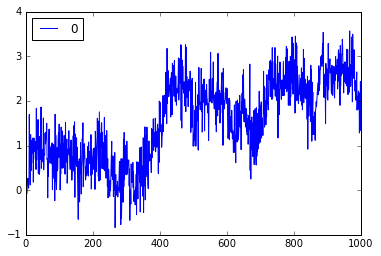

In [95]:
y = np.array([0])
mi = np.array([0])
gamma = np.array([0])

xi = np.array([0])
omega = np.array([0])
ep = np.array([0])

for i in range(1,n):

    # Level equation
    xi = np.append(xi,np.random.normal(scale=sigmaXi))
    mi = np.append(mi,mi[i-1]+xi[i])
    
    # Seasonality equation
    omega = np.append(omega,np.random.normal(scale=sigmaOmega))
    holder = 0
    if i-1 >= 0:
        holder -= gamma[i-1] * theta1

    
    gamma = np.append(gamma,holder+omega[i])
    
    # Series equation
    ep = np.append(ep,np.random.normal(scale=sigmaEpsilon))
    y = np.append(y,mi[i]+gamma[i]+ep[i])

y = pd.DataFrame(y) 
mi = pd.DataFrame(mi) 
gamma = pd.DataFrame(gamma) 
y.plot()

## Filtering States

In [79]:
T = pd.DataFrame([
        [1,0,],
        [0,0.7,],
    ])
T

,0,1
0,1,0.0
1,0,0.7


In [80]:
Z = pd.DataFrame([
        [1,1],
    ])
Z

,0,1
0,1,1


In [81]:
R = pd.DataFrame([
        [1,0],
        [0,1],
    ])
R

,0,1
0,1,0
1,0,1


In [82]:
H = pd.DataFrame([0.3])
H

,0
0,0.3


In [83]:

Q = pd.DataFrame([
        [0.1,0],
        [0,0.2],
    ])
Q

,0,1
0,0.1,0.0
1,0.0,0.2


In [84]:
a1 = pd.DataFrame([0,0])
a1

,0
0,0
1,0


In [85]:
P1 = pd.DataFrame(np.diag([1,1]))
P1

,0,1
0,1,0
1,0,1


In [96]:
kf = KalmanFilter(y=y, Z=Z, H=H, T=T, Q=Q, a1=a1, P1=P1, R=R, nStates=2)
kf.runFilter()

In [103]:
kf.a.head()

,0,1
0,0.000000,0.000000
1,0.142828,0.068316
2,0.112671,0.034583
3,0.023327,-0.018838
4,0.067927,0.010500


In [104]:
kf.yhat.head()

,0
0,0.000000
1,0.211144
2,0.147254
3,0.004489
4,0.078427


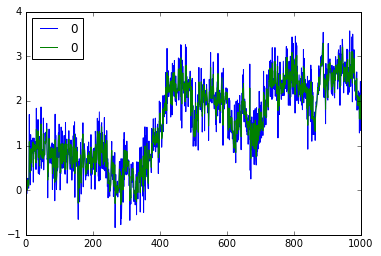

In [97]:
pd.concat([kf.y , kf.yhat],axis=1).plot()

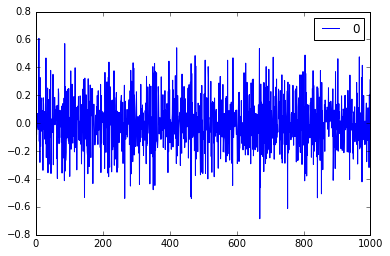

In [102]:
(kf.y-kf.yhat).plot()

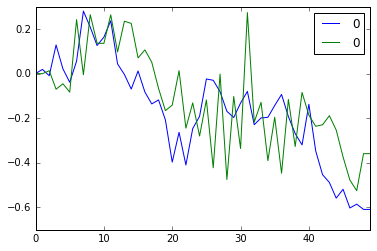

In [88]:
pd.concat([mi , kf.a[0]],axis=1).plot()

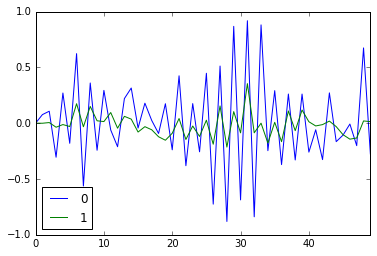

In [89]:
pd.concat([gamma , kf.a[1]],axis=1).plot()

In [90]:
kf.yhat.head()

,0
0,0.000000
1,-0.001081
2,0.018569
3,-0.106193
4,-0.058006


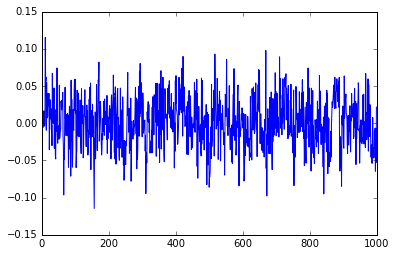

In [100]:
(kf.yhat[0]-kf.a[0]-kf.a[1]*theta1).plot()

# Maximum likelihood estimates

# Generating the data for $\theta_1=0.7$

We have to choose all parameter values plus the initial states

$$\gamma_t = \gamma_{t-1} = \gamma_{t-2} = 0$$
$$\theta_1 = 0.7$$
$$\sigma^2_\xi = 0.1$$
$$\sigma^2_\omega = 0.2$$
$$\sigma^2_\epsilon = 0.3$$

$$y_t = \mu_t + \gamma_t + \epsilon_t, \qquad \epsilon_t \sim NID(0,\sigma^2_\epsilon)$$

$$\mu_{t+1} = \mu_t + \xi_t, \qquad \xi_t \sim NID(0,\sigma^2_\xi) $$

$$\gamma_{t+1} = \theta_1 \gamma_{t} + \omega_t \sim NID(0,\sigma^2_\omega) $$


$$
T_t = 
\begin{bmatrix} 
1 & 0  \\
0 & \theta_1 \\
\end{bmatrix}
$$



In [15]:
n = 1000
theta1 = 0.3
sigmaXi = 0.1
sigmaOmega = 0.2
sigmaEpsilon = 0.3

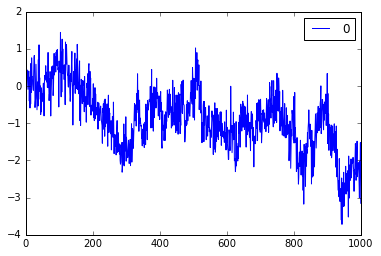

In [16]:
y = np.array([0])
mi = np.array([0])
gamma = np.array([0])

xi = np.array([0])
omega = np.array([0])
ep = np.array([0])

for i in range(1,n):

    # Level equation
    xi = np.append(xi,np.random.normal(scale=sigmaXi))
    mi = np.append(mi,mi[i-1]+xi[i])
    
    # Seasonality equation
    omega = np.append(omega,np.random.normal(scale=sigmaOmega))
    holder = 0
    if i-1 >= 0:
        holder -= gamma[i-1] * theta1

    
    gamma = np.append(gamma,holder+omega[i])
    
    # Series equation
    ep = np.append(ep,np.random.normal(scale=sigmaEpsilon))
    y = np.append(y,mi[i]+gamma[i]+ep[i])

y = pd.DataFrame(y) 
mi = pd.DataFrame(mi) 
gamma = pd.DataFrame(gamma) 
y.plot()

In [57]:
def wrapper(theta):
    T = pd.DataFrame([
        [1,0,],
        [0,-theta[0]],
    ])

    H = pd.DataFrame([theta[1]])

    Q = pd.DataFrame([
        [theta[2],0],
        [0,theta[3]],
    ])

    kf = KalmanFilter(y=y, 
                      Z=Z.astype(float), 
                      H=H.astype(float), 
                      T=T.astype(float), 
                      Q=Q.astype(float), 
                      a1=a1.astype(float), 
                      P1=P1.astype(float), 
                      R=R.astype(float), 
                      nStates=2)    

    return kf.likelihood()


In [58]:
KalmanFilter(y=y, Z=Z, H=H, T=T, Q=Q, a1=a1, P1=P1, R=R, nStates=2).likelihood()

912.92020081221028

In [64]:
minimize(wrapper,np.array([0.0,1.0,1.0,1.0]), 
         options={'disp':True, 'maxiter':200}, 
         bounds = [(-5,5),(0.0001,5),(None,None),(None,None)],
         method='SLSQP',
         )

C:\Anaconda3\lib\site-packages\scipy\optimize\slsqp.py:341: RuntimeWarning: invalid value encountered in greater
  bnderr = bnds[:, 0] > bnds[:, 1]
O:\SALES\Fundos de Mercado\Notebooks\Bayesian Econometrics\KalmanFilter.py:168: RuntimeWarning: invalid value encountered in log
  ll += np.log(det(self.Ft[i])) +  self.vt[i].T.dot(inv(self.Ft[i])).dot(self.vt[i])
C:\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1821: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Iteration limit exceeded    (Exit mode 9)
            Current function value: nan
            Iterations: 201
            Function evaluations: 3186
            Gradient evaluations: 201


     fun: nan
     jac: array([ nan,  nan,  nan,  nan])
 message: 'Iteration limit exceeded'
    nfev: 3186
     nit: 201
    njev: 201
  status: 9
 success: False
       x: array([ nan,  nan,  nan,  nan])

In [65]:
minimize(wrapper,np.array([0.0,1.0,1.0,1.0]), 
         options={'disp':True, 'maxiter':200}, 
         bounds = ((-5,5),(None,None),(None,None),(None,None)),
         method='SLSQP',
         )

C:\Anaconda3\lib\site-packages\scipy\optimize\slsqp.py:341: RuntimeWarning: invalid value encountered in greater
  bnderr = bnds[:, 0] > bnds[:, 1]
O:\SALES\Fundos de Mercado\Notebooks\Bayesian Econometrics\KalmanFilter.py:168: RuntimeWarning: invalid value encountered in log
  ll += np.log(det(self.Ft[i])) +  self.vt[i].T.dot(inv(self.Ft[i])).dot(self.vt[i])


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5473.491214475649
            Iterations: 26
            Function evaluations: 223
            Gradient evaluations: 26


     fun: 5473.491214475649
     jac: array([-0.01330566, -0.08807373, -0.69604492, -0.14855957])
 message: 'Optimization terminated successfully.'
    nfev: 223
     nit: 26
    njev: 26
  status: 0
 success: True
       x: array([ 0.35832767,  0.09454317,  0.0092511 ,  0.03403833])

In [66]:
minimize(wrapper,np.array([0.0,1.0,1.0,1.0]), 
         options={'disp':True, 'maxiter':200}, 
#          bounds = ((-5,5),(None,None),(None,None),(None,None)),
         method='SLSQP',
         )

O:\SALES\Fundos de Mercado\Notebooks\Bayesian Econometrics\KalmanFilter.py:168: RuntimeWarning: invalid value encountered in log
  ll += np.log(det(self.Ft[i])) +  self.vt[i].T.dot(inv(self.Ft[i])).dot(self.vt[i])
C:\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1821: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


KeyboardInterrupt: 

# Bayesian Estimates

## Metropolis Hastings

---
**Metropolis-Hastings Algoritm**

Guess $\theta^{(0)}$ and for $i=0$ until $n$: 
1. $\theta=\theta^{(i)}$
Draw $\theta'\sim q(\theta'|\theta)$
2. Compute $r=\min(1,\alpha)$ where $\alpha= \frac{p(\theta')q(\theta|\theta')}{p(\theta)q(\theta'|\theta)}$
4. Draw $u\sim U(0,1)$
5. $\theta^{(i+1)}=\begin{cases}\theta' & \text{if $u<r$}\\\theta & \text{if $u\geq r$}\end{cases}$

---

In [17]:
def wrapper(theta):
    T = pd.DataFrame([
        [1,0,],
        [0,-theta[0]],
    ])

    H = pd.DataFrame([theta[1]])

    Q = pd.DataFrame([
        [theta[2],0],
        [0,theta[3]],
    ])

    kf = KalmanFilter(y=y, 
                      Z=Z.astype(float), 
                      H=H.astype(float), 
                      T=T.astype(float), 
                      Q=Q.astype(float), 
                      a1=a1.astype(float), 
                      P1=P1.astype(float), 
                      R=R.astype(float), 
                      nStates=2)    

    return kf.likelihood()

In [18]:
def posterior(theta,priorMeans, priorVariances):
    
    temp = 1
    for i in range(0,priorMeans.shape[0]):
        temp *= norm.pdf(theta[i],priorMeans[i],priorVariances[i])
    
    return wrapper(theta) * temp

In [27]:
# %%cython

sample = 1000

thetaMH = []
accept = np.zeros([sample])

thetaMH.append(np.array([0.5,0.1,0.1,0.1]))

sigmas = np.array([1,2,2,2])


priorMeans = np.array([0,0,0,0])

priorVariances = 3 * np.ones(4)

for i in range(1,sample):
    disturbance = np.multiply(np.random.randn(thetaMH[0].shape[0]),sigmas)
#     print(disturbance)
    thetaTemp = (thetaMH[i-1] + disturbance)
    lalpha = np.log(posterior(thetaTemp,priorMeans, priorVariances)) - np.log(posterior(thetaMH[i-1],priorMeans, priorVariances))
    r = np.min([1, np.exp(lalpha)])
    
    u = np.random.uniform()
    
    if u < r:
        accept[i] = 1
        thetaMH.append(thetaTemp)
    else:
        thetaMH.append(thetaMH[i-1])
    
    

In [28]:
burn = 100

In [29]:
post = pd.DataFrame(thetaMH)

In [30]:
accept.sum() / accept.shape[0]

0.38600000000000001

In [31]:
parameter = 0

In [32]:
post[parameter].iloc[burn:].median()

0.1683939344497956

In [33]:
post[parameter].iloc[burn:].mean()

0.32525704106143205

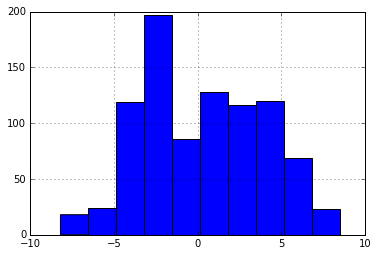

In [34]:
post[parameter].iloc[burn:].hist()

* iniciar com parametro max verossim
* mudar o rando walk para ficar entre zero e um
* tirar o perform checks

Duvidas:

* se aquilo eh ruido branco
* se integral de monte carlo eh igual tirar a media
